<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task" data-toc-modified-id="Task-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Solution" data-toc-modified-id="Solution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Solution</a></span><ul class="toc-item"><li><span><a href="#Decision-Tree-Implementation-incl-Weights" data-toc-modified-id="Decision-Tree-Implementation-incl-Weights-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Decision Tree Implementation incl Weights</a></span></li><li><span><a href="#Adaboost-implementation" data-toc-modified-id="Adaboost-implementation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Adaboost implementation</a></span></li><li><span><a href="#Comparison-of-our-adaboost-to-sklearn-adaboost" data-toc-modified-id="Comparison-of-our-adaboost-to-sklearn-adaboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Comparison of our adaboost to sklearn adaboost</a></span></li><li><span><a href="#Confusion-matrix-with-depth-1-decision-stumps" data-toc-modified-id="Confusion-matrix-with-depth-1-decision-stumps-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Confusion matrix with depth 1 decision stumps</a></span></li><li><span><a href="#Plot-confusion-matrix-with-depth-2-decision-trees" data-toc-modified-id="Plot-confusion-matrix-with-depth-2-decision-trees-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Plot confusion matrix with depth 2 decision trees</a></span></li></ul></li><li><span><a href="#Results-and-discussion,-not-adapted-to-adaboost-yet" data-toc-modified-id="Results-and-discussion,-not-adapted-to-adaboost-yet-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results and discussion, not adapted to adaboost yet</a></span></li></ul></div>

# Task

Implement AdaBoost using Python (incl. Numpy etc.) and use it on the SPAM-Dataset1.The weak classifiers should be decision stumps (i.e. decision trees with one node).

(a) Print a confusion matrix.

(b) Is AdaBoost better when using stronger weak learners? Why or why not? Compareyour results to using depth-2 decision trees.

# Setup

In [1]:
import pandas as pd
import numpy as np
import random

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import math

from collections import namedtuple

Tree = namedtuple('Tree', 'features model')

In [2]:
def generate_csv():
    with open('data/spambase.cutnames') as h_reader, open(
        'data/spambase.data') as d_reader, open(
        'data/spambase.csv', 'w') as writer:
    
        headers = [line.split(':')[0] for line in h_reader] + ['spam']
        writer.write(','.join(headers) + '\n')
        writer.writelines(d_reader.readlines())

# generate_csv()

In [3]:
df = pd.read_csv('data/spambase.csv')
y = df['spam'].copy()
#for AdaBoost: y = {-1,1}
y[y==0] = -1
X = df.drop(['spam'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Solution

## Decision Tree Implementation incl Weights

In [4]:
class Node:
    def __init__(self):

        # links to the left and right child nodes
        self.right = None
        self.left = None

        # derived from splitting criteria
        self.column = None
        self.threshold = None

        # probability for object inside the Node to belong for each of the given classes
        self.ps = None
        # probability of a sample to reach this Node
        self.rp= None
        # depth of the given node
        self.depth = None
        self.impurity = None 

        # if it is the root Node or not
        self.is_terminal = False

New weighted node probabilities found in nodeWeightedPs and in 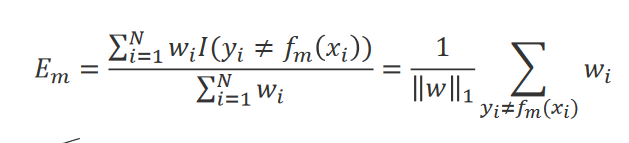

In [13]:
def posnegmax(array):
    '''
    funtion to return highest 
    '''
    absar = np.absolute(array)
    maxpos = np.argmax(absar)
    if maxpos==0:
        maxpos = -1
    return maxpos

def TF(argument):
    return 1 if argument else 0

In [14]:
class DecisionTreeClassifierWeights:
    '''Adapted to take data weights when being built'''
    def __init__(self, max_depth = 3, min_samples_leaf = 1, min_samples_split = 2):
        #now takes weights in order to be passed on through generation of several trees
        
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        
        
        # Decision tree itself
        self.Tree = None
        
    
    def nodeWeightedPs(self, y, weights):
        '''
        Calculates probability of class in a given node
        '''
        #Makes no sense to use numpy arrays here, since the overhead of creating them is way to large.
        #modified in order to accomodate weight
        return [ np.sum(weights[y == one_class]) / np.sum(weights)*one_class for one_class in self.classes]
    

    def gini(self, ps):
        '''
        Calculates gini criterion
        '''
        #Gini Index regarding sum_1^k(p_mk*(1-p_mk)) can also be formulated as 1-sum_1^k(p_mk) since the sum_1^k(p_mk)=1
        #Using standard sum and not np.sum since p is no longer a numpy array
        return 1-sum([p ** 2 for p in ps])
    
    def calcImpurity(self, y, weights):
        '''
        Wrapper for the impurity calculation. Calculates probas first and then passses them
        to the Gini criterion
        '''
        return self.gini(self.nodeWeightedPs(y, weights))
    
    def calcBestSplit(self, X, y, impurityBefore, weights):
        '''
        Calculates the best possible split for the concrete node of the tree
        '''
        
        bestSplitCol = None
        bestThresh = None
        bestImpurityLeft = None
        bestImpurityRight = None
        bestInfoGain = -999
        
        #impurityBefore = self.calcImpurity(y)
        
        # for each column (feature) in X
        for col in range(X.shape[1]):
            x_col = X[:,col]
                        
            # for each value in the column (instance of the feature=)
            for x_i in np.unique(x_col):
                threshold = x_i
                y_right = y[x_col>threshold]
                weights_right = weights[x_col>threshold]
                
                y_left = y[x_col<=threshold]
                weights_left = weights[x_col<=threshold]
                
                if y_right.shape[0] == 0 or y_left.shape[0] == 0:
                    continue
                    
                # calculate impurity for the right and left nodes
                impurityRight = self.calcImpurity(y_right, weights_right)
                #print("ImpurityRight: {}".format(impurityRight))
                impurityLeft = self.calcImpurity(y_left, weights_left)
                #print("ImpurityLeft: {}".format(impurityLeft))

                
                # calculate information gain
                infoGain = impurityBefore
                infoGain -= (impurityLeft * y_left.shape[0] / y.shape[0]) + (impurityRight * y_right.shape[0] / y.shape[0])
                # is this infoGain better then all other?
                if infoGain > bestInfoGain:
                    bestSplitCol = col
                    bestThresh = threshold
                    bestInfoGain = infoGain
                    bestImpurityLeft = impurityLeft
                    bestImpurityRight = impurityRight
                    
        #print("bestImpurityLeft {}".format(bestImpurityLeft))
        #print("bestImpurityRight {}".format(bestImpurityRight))

        # if we still didn't find the split
        if bestInfoGain == -999:
            #print("nobetterinfogaain")
            return None, None, None, None, None, None, None, None, None, None
        
        # making the best split
        
        x_col = X[:, bestSplitCol]
        x_left, x_right = X[x_col <= bestThresh, :], X[x_col > bestThresh, :]
        y_left, y_right = y[x_col <= bestThresh], y[x_col > bestThresh]
        weights_left, weights_right = weights[x_col <= bestThresh], weights[x_col > bestThresh]
        
        return bestSplitCol, bestThresh, x_left, y_left, bestImpurityLeft, x_right, y_right, bestImpurityRight, weights_right, weights_left
    
    def buildDT(self, X, y, node, weights):
        '''
        Recursively builds decision tree from the top to bottom
        '''
        
        # checking for the terminal conditions
        
        if node.depth >= self.max_depth:
            node.is_terminal = True
            return
        
        if X.shape[0] < self.min_samples_split:
            node.is_terminal = True
            return
        
        if self.classes.shape[0] == 1:
            node.is_terminal = True
            return
        
        # calculating current split
        splitCol, thresh, x_left, y_left, impLeft, x_right, y_right, impRight, weights_right, weights_left = self.calcBestSplit(X, y, node.impurity, weights)
        if splitCol is None:
            node.is_terminal = True
            return
            
        if x_left.shape[0] < self.min_samples_leaf or x_right.shape[0] < self.min_samples_leaf:
            node.is_terminal = True
            return
        
        node.column = splitCol
        node.threshold = thresh
        
        # creating left and right child nodes
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.ps = self.nodeWeightedPs(y_left, weights_left)
        #print("Node left ps: {}".format(node.left.ps))
        node.left.rp = y_left.shape[0]/y.shape[0]
        node.left.impurity = impLeft
        
        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.ps = self.nodeWeightedPs(y_right, weights_right)
        #print("Node right ps: {}".format(node.right.ps))

        node.right.rp = y_right.shape[0]/y.shape[0]
        node.right.impurity = impRight
        
        # splitting recursevely
        self.buildDT(x_right, y_right, node.right, weights_right)
        self.buildDT(x_left, y_left, node.left, weights_left)
    
    
    def fit(self, X, y, initial_weights):
        '''
        Standard fit function to run all the model training
        '''
        #Turn it into numpy array, in case it's a pandas dataframe or a list
        X = self.to_numpy(X)
        y = self.to_numpy(y)
        
        self.weights = self.to_numpy(initial_weights)

        self.classes = np.unique(y)
        self.features = np.array(X.shape[1])
        # root node creation
        self.Tree = Node()
        self.Tree.depth = 1
        self.Tree.ps = self.nodeWeightedPs(y, self.weights)
        self.Tree.impurity = self.calcImpurity(y, self.weights)
        self.Tree.rp = 1
        self.buildDT(X, y, self.Tree, self.weights)
        
        
        
        # calculating new weights
        self.class_weight = self.calcClassifierWeight(X,y,self.weights)
        
        self.new_weights = self.calcNewWeights(X,y,self.weights, self.class_weight)
        
        return self.class_weight, self.new_weights
        
        
    
    def predictSample(self, x, node):
        '''
        Passes one object through decision tree and return the probability of it to belong to each class
        '''
       
    
        # if we have reached the terminal node of the tree
        if node.is_terminal:
            return node.ps
        
        if x[node.column] > node.threshold:
            ps = self.predictSample(x, node.right)
        else:
            ps = self.predictSample(x, node.left)
            
        return ps
    
    def predict(self, X):
        '''
        Returns the labels for each X
        '''
        
        X = self.to_numpy(X)
            
        predictions = []
        for x in X:
            pred = posnegmax(self.predictSample(x, self.Tree))
            predictions.append(pred)
        
        return np.asarray(predictions)
    
    def calcWeightedError(self, X, y, weights):
        '''
        Calculate weighted Error of the predictions
        '''
        predictions = self.predict(X)
        #print("Calculate weighted Error: {}".format(np.sum(weights[y != predictions]) / np.sum(weights)))
        return np.sum(weights[y != predictions]) / np.sum(weights)

    
    def calcClassifierWeight(self, X, y, weights):
        '''
        calculate classifier Weight alpha from weighted Error
        '''
       
        we = self.calcWeightedError(X,y,weights) 
        #print("Calculate classifier weight: {}".format(math.log((1-we)/we)))
        return math.log((1-we)/we)
    """
    def calcNewWeights(self, X, y, weights, classifierWeight):
        '''
        calculate new weights
        '''
        predictions = self.predict(X)
        
        new_weights = weights*np.exp(-classifierWeight*y*predictions)
        return new_weights
    """
    
    def calcNewWeights(self, X, y, weights, classifierWeight):
        '''
        calculate new weights
        https://medium.com/analytics-vidhya/implementing-an-adaboost-classifier-from-scratch-e30ef86e9f1b
        '''
        predictions = self.predict(X)
        
        new_weights = [weights[i]*np.exp(classifierWeight*TF(y[i]!=predictions[i].reshape(1,-1))) for i in range(X.shape[0])] 
        return new_weights
        
        
        
        
        
    def to_numpy(self, obj):
        if isinstance(obj, pd.DataFrame) or isinstance(obj, pd.Series):
            return obj.to_numpy()
        if  isinstance(obj,list):
            return np.array(obj)
        return obj
       
    def printtree(self):
        print("Tree structure")
        self.printnode(self.Tree)
        
    def printnode(self,node):
        offset = ' '*node.depth
        if (node.is_terminal == True):
            print(offset,"[y ={}, elementshare = {}, impurity = {}]".format(posnegmax(node.ps), node.rp, node.impurity))
        else:
            print(offset,"[ X{} < {}; elementshare = {}, impurity = {}]".format(node.column, node.threshold, node.rp, node.impurity))
            self.printnode(node.left)
            self.printnode(node.right)
    
    def calcImportance(self, node, parentP, priorImpurity):
        return parentP*node.rp*(priorImpurity-node.impurity)
    
    
    def calcrp(self, node, p, impurity, col, infoGain):
        p = p*node.rp
        if (node.column == col):
            infoGain[1,col] += self.calcImportance(node.left, p, node.impurity)
            infoGain[1,col] += self.calcImportance(node.right, p, node.impurity)
        if (node.is_terminal == True):
            return
        else:
            self.calcrp(node.left, p, node.impurity, col, infoGain)
            self.calcrp(node.right, p, node.impurity, col, infoGain)
        
        
    def calcFeatureImportance(self):
        p = 1
        impurity = self.Tree.impurity
        infoGain = np.array([np.array(range(0,self.features)).astype(int),np.zeros(self.features)])
        for col in range(0,self.features):
            self.calcrp(self.Tree, p, impurity, col, infoGain)
        return infoGain.T[infoGain.T[:,1].argsort()[::-1],:]

In [15]:
model = DecisionTreeClassifierWeights(max_depth = 2, min_samples_leaf = 1, min_samples_split = 2)
initial_weights = [1/X_train.shape[0]]*X_train.shape[0]
cw, nws = model.fit(X_train, y_train, initial_weights)
print(cw)
print(sum(nws))
print(nws[0:10])

1.3911684568781362
1.6015574302400684
[0.0003244646333549643, 0.0003244646333549643, 0.0003244646333549643, 0.0003244646333549643, 0.0003244646333549643, 0.0003244646333549643, 0.0003244646333549643, 0.0003244646333549643, 0.0003244646333549643, 0.0003244646333549643]


In [16]:
model.printtree()
print("Accuracy: {}".format(accuracy_score(y_test, model.predict(X_test))))

Tree structure
  [ X52 < 0.044000000000000004; elementshare = 1, impurity = 0.4725603144169681]
   [y =-1, elementshare = 0.744970798182998, impurity = 0.3426531826293874]
   [y =1, elementshare = 0.25502920181700195, impurity = 0.24072671237754828]
Accuracy: 0.7820934825543121


## Adaboost implementation

In [17]:
class Adaboost(BaseEstimator, ClassifierMixin):
    def __init__(self, trees_number, tree_factory=DecisionTreeClassifierWeights):
        self._trees_number = trees_number
        self._tree_factory = tree_factory
        
        self._bag_size = None
        self._N = None
        self._trees = []

    def fit(self, X, y, tree_depth, initial_weights):
        X = self.to_numpy(X)
        y = self.to_numpy(y)
        self._depth = tree_depth
        self._N = int(X.shape[1] ** .5)
        self._bag_size = int(X.shape[0] * 0.1)

        self._trees = []
        self._classification_weights = []
        weights = initial_weights
        for i in range(self._trees_number):
            print(i)
            class_weights, weights, tree = self._build_tree(X,y,self._depth, weights)
            self._trees.append(tree)
            print(class_weights)
            self._classification_weights.append(class_weights)
            
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        X = self.to_numpy(X)
        response = self._classify(self._trees[0], X) * self._classification_weights[0]
        for t in range(1,len(self._trees)):
            tee = self._trees[t]
            cw = self._classification_weights[t]
            response = np.vstack((response, (self._classify(tee, X) * cw)))
            

        return np.sign(response.sum(axis=0))

    def _build_tree(self, X, y, depth, weights):
        clf = self._tree_factory(max_depth=depth, min_samples_leaf=1, min_samples_split=2)
        cw, nws = clf.fit(X, y, weights)
        clf.printtree()
        return cw, nws, clf

    def _classify(self, tree, X):
        return tree.predict(X)
    
    def to_numpy(self, obj):
        if isinstance(obj, pd.DataFrame) or isinstance(obj, pd.Series):
            return obj.to_numpy()
        if  isinstance(obj,list):
            return np.array(obj)
        return obj

## Comparison of our adaboost to sklearn adaboost

In [18]:
ada = Adaboost(trees_number=5,tree_factory=DecisionTreeClassifierWeights)
inititial_weights = np.array([1/y_train.shape[0]]*y_train.shape[0])
ada.fit(X_train, y_train, 2, initial_weights)
y_pred = ada.predict(X_test)

print("Accuracy of custom adaboost: {}".format(accuracy_score(y_test,y_pred)))

0
Tree structure
  [ X52 < 0.044000000000000004; elementshare = 1, impurity = 0.4725603144169681]
   [y =-1, elementshare = 0.744970798182998, impurity = 0.3426531826293874]
   [y =1, elementshare = 0.25502920181700195, impurity = 0.24072671237754828]
1.3911684568781362
1
Tree structure
  [ X51 < 0.076; elementshare = 1, impurity = 0.4955109437532452]
   [y =-1, elementshare = 0.5840363400389358, impurity = 0.4174721801602421]
   [y =1, elementshare = 0.41596365996106427, impurity = 0.31214429374361186]
1.1197107484397817
2
Tree structure
  [ X24 < 0.09; elementshare = 1, impurity = 0.4903086589828882]
   [y =1, elementshare = 0.7667099286177806, impurity = 0.44264961728546326]
   [y =-1, elementshare = 0.23329007138221933, impurity = 0.17479808792394902]
0.8957553605037765
3
Tree structure
  [ X6 < 0.0; elementshare = 1, impurity = 0.4866466135174359]
   [y =-1, elementshare = 0.8244646333549643, impurity = 0.4370129195271084]
   [y =1, elementshare = 0.1755353666450357, impurity = 0.

In [19]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=5,algorithm="SAMME")
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy of sklearn adaboost: {}".format(accuracy_score(y_test,y_pred)))

Accuracy of sklearn adaboost: 0.8663594470046083


## Confusion matrix with depth 1 decision stumps

0
Tree structure
  [ X52 < 0.044000000000000004; elementshare = 1, impurity = 0.4725603144169681]
   [y =-1, elementshare = 0.744970798182998, impurity = 0.3426531826293874]
   [y =1, elementshare = 0.25502920181700195, impurity = 0.24072671237754828]
1.3911684568781362
1
Tree structure
  [ X51 < 0.076; elementshare = 1, impurity = 0.4955109437532452]
   [y =-1, elementshare = 0.5840363400389358, impurity = 0.4174721801602421]
   [y =1, elementshare = 0.41596365996106427, impurity = 0.31214429374361186]
1.1197107484397817
2
Tree structure
  [ X24 < 0.09; elementshare = 1, impurity = 0.4903086589828882]
   [y =1, elementshare = 0.7667099286177806, impurity = 0.44264961728546326]
   [y =-1, elementshare = 0.23329007138221933, impurity = 0.17479808792394902]
0.8957553605037765
3
Tree structure
  [ X6 < 0.0; elementshare = 1, impurity = 0.4866466135174359]
   [y =-1, elementshare = 0.8244646333549643, impurity = 0.4370129195271084]
   [y =1, elementshare = 0.1755353666450357, impurity = 0.

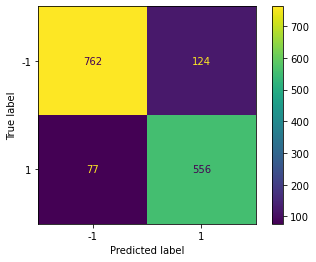

In [20]:
ada = Adaboost(trees_number=10,tree_factory=DecisionTreeClassifierWeights)
inititial_weights = np.array([1/y_train.shape[0]]*y_train.shape[0])
ada.fit(X_train, y_train, 2, initial_weights)
y_pred = ada.predict(X_test)
print("Accuracy of custom adaboost, 10 trees, depth 1: {}".format(accuracy_score(y_test,y_pred)))
plot_confusion_matrix(ada, X_test, y_test)

## Plot confusion matrix with depth 2 decision trees


0
Tree structure
  [ X52 < 0.044000000000000004; elementshare = 1, impurity = 0.4725603144169681]
   [ X6 < 0.05; elementshare = 0.744970798182998, impurity = 0.3426531826293874]
    [y =-1, elementshare = 0.914198606271777, impurity = 0.25842292922444754]
    [y =1, elementshare = 0.085801393728223, impurity = 0.12327037542837993]
   [ X24 < 0.38; elementshare = 0.25502920181700195, impurity = 0.24072671237754828]
    [y =1, elementshare = 0.9249363867684478, impurity = 0.14451430290485456]
    [y =-1, elementshare = 0.07506361323155217, impurity = 0.18270611893134125]
1.9143941658287025
1
Tree structure
  [ X26 < 0.0; elementshare = 1, impurity = 0.4900344958937899]
   [ X51 < 0.07400000000000001; elementshare = 0.8241401687216093, impurity = 0.45806338710514216]
    [y =-1, elementshare = 0.5255905511811023, impurity = 0.490672891164495]
    [y =1, elementshare = 0.4744094488188976, impurity = 0.28338923350031053]
   [ X52 < 0.055; elementshare = 0.17585983127839067, impurity = 0.00

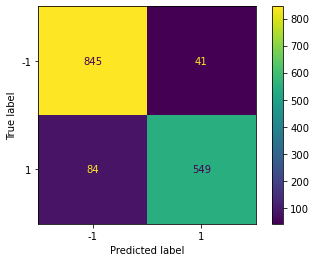

In [21]:
ada = Adaboost(trees_number=10,tree_factory=DecisionTreeClassifierWeights)
inititial_weights = np.array([1/y_train.shape[0]]*y_train.shape[0])
ada.fit(X_train, y_train, 3, initial_weights)
y_pred = ada.predict(X_test)
print("Accuracy of custom adaboost, 10 trees, depth 2: {}".format(accuracy_score(y_test,y_pred)))
plot_confusion_matrix(ada, X_test, y_test)

# Results and discussion, not adapted to adaboost yet

Our adaboost implementation reaches the same accuracy as the sklearn implementation. It is set to show the trees and the conribution of the individual trees to the boosted tree.

In our case, AdaBoost with a depth of two is more accurate then with a depth of one (0.91 to 0.86, both TP and TN are larger). Deeper Trees can generally have decision boundaries for more dimensions, therefore they can fit better to the overall data. When these trees are combined, individual trees that are more accurate can form more accurate combined classifiers.
However, with a higher number of trees that might change, as more trees can also bring the opportunity to cover more dimensions